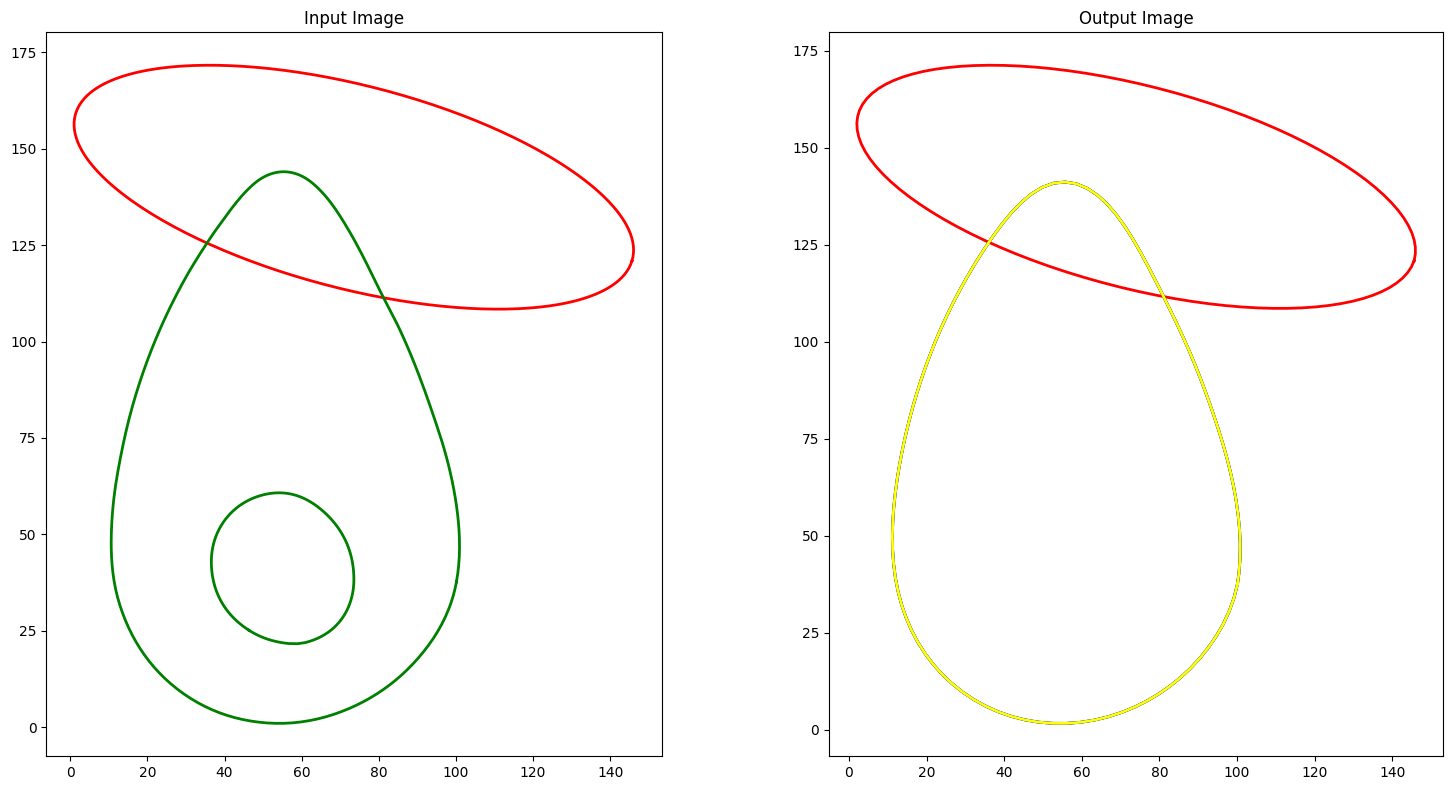

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.neighbors import NearestNeighbors
import math

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, title, ax):
    colours = ['red', 'green', 'blue', 'yellow', 'purple']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        if isinstance(XYs, list):
            for XY in XYs:
                ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
        else:
            ax.plot(XYs[:, 0], XYs[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)

def fit_circle(points):
    def calc_R(xc, yc):
        return np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)

    def f_2(c):
        Ri = calc_R(*c)
        return np.sum((Ri - Ri.mean()) ** 2)

    center_estimate = np.mean(points, axis=0)
    center = minimize(f_2, center_estimate).x
    radius = calc_R(*center).mean()
    return center, radius

def fit_ellipse(points):
    x = points[:, 0]
    y = points[:, 1]
    x_m = np.mean(x)
    y_m = np.mean(y)

    def calc_R(params):
        a, b, phi = params
        return (x - x_m) * np.cos(phi) + (y - y_m) * np.sin(phi), (y - y_m) * np.cos(phi) - (x - x_m) * np.sin(phi)

    def f_2(params):
        a, b, phi = params
        R = calc_R(params)
        return np.sum((R[0] ** 2 / a ** 2 + R[1] ** 2 / b ** 2 - 1) ** 2)

    center_estimate = (np.std(x), np.std(y), 0)
    a, b, phi = minimize(f_2, center_estimate).x
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_x = x_m + a * np.cos(theta) * np.cos(phi) - b * np.sin(theta) * np.sin(phi)
    ellipse_y = y_m + a * np.cos(theta) * np.sin(phi) + b * np.sin(theta) * np.cos(phi)
    return np.vstack((ellipse_x, ellipse_y)).T

def perpendicular_distance(point, line_start, line_end):
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    else:
        return np.linalg.norm(np.cross(line_end - line_start, line_start - point)) / np.linalg.norm(line_end - line_start)

def ramer_douglas_peucker(points, epsilon):
    dmax = 0
    index = 0
    end = len(points)

    for i in range(1, end - 1):
        d = perpendicular_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    if dmax > epsilon:
        rec_results1 = ramer_douglas_peucker(points[:index + 1], epsilon)
        rec_results2 = ramer_douglas_peucker(points[index:], epsilon)
        result_list = np.vstack((rec_results1[:-1], rec_results2))
    else:
        result_list = np.array([points[0], points[-1]])

    return result_list

def fit_bezier(points, n_points=100):
    n = len(points) - 1
    binom = np.array([math.factorial(n) / (math.factorial(i) * math.factorial(n - i)) for i in range(n + 1)])
    t = np.linspace(0, 1, n_points)
    curve = np.zeros((n_points, 2))
    for i in range(n + 1):
        curve[:, 0] += binom[i] * (1 - t) ** (n - i) * t ** i * points[i, 0]
        curve[:, 1] += binom[i] * (1 - t) ** (n - i) * t ** i * points[i, 1]
    return curve

def icp(source, target, max_iterations=100, tolerance=1e-5):
    source = source.copy()
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(target)
    for i in range(max_iterations):
        distances, indices = nbrs.kneighbors(source)
        matched_target = target[indices[:, 0]]
        centroid_source = np.mean(source, axis=0)
        centroid_target = np.mean(matched_target, axis=0)
        H = np.dot((source - centroid_source).T, matched_target - centroid_target)
        U, _, Vt = np.linalg.svd(H)
        R = np.dot(Vt.T, U.T)
        t = centroid_target - np.dot(R, centroid_source)
        source = np.dot(source, R.T) + t
        if np.mean(distances) < tolerance:
            break
    return source

def merge_segments(paths_XYs, overlap_threshold=5):
    merged_paths = []
    for i, path1 in enumerate(paths_XYs):
        merged = False
        for j, path2 in enumerate(paths_XYs[i + 1:], i + 1):
            if np.linalg.norm(np.mean(path1[0], axis=0) - np.mean(path2[0], axis=0)) < overlap_threshold:
                merged_path = np.vstack([path1[0], icp(path1[0], path2[1])])
                merged_path = np.unique(merged_path, axis=0)
                merged_paths.append(merged_path)
                merged = True
        if not merged:
            merged_paths.append(path1[0])
            merged_paths.append(path2[0])
    return merged_paths

def regularize_paths(paths_XYs, epsilon):
    merged_paths = merge_segments(paths_XYs)

    simplified_paths = []
    for path in merged_paths:
        simplified_segment = ramer_douglas_peucker(path, epsilon)
        fitted_segment = []
        if len(simplified_segment) > 11 and len(simplified_segment) < 13:
            center, radius = fit_circle(simplified_segment)
            theta = np.linspace(0, 2 * np.pi, 100)
            x = center[0] + radius * np.cos(theta)
            y = center[1] + radius * np.sin(theta)
            fitted_segment = np.vstack((x, y)).T
        elif len(simplified_segment) > 11 and np.mean(simplified_segment[:, 1]) < 50:
            fitted_segment = fit_ellipse(simplified_segment)
        elif len(simplified_segment) > 6 and len(simplified_segment) < 10:
            fitted_segment = fit_bezier(path)
        else:
            fitted_segment = simplified_segment

        simplified_paths.append(fitted_segment)

    return simplified_paths

csv_path1 = "occlusion1_sol.csv"

paths_XYs = read_csv(csv_path1)

epsilon = 8
fitted_paths = regularize_paths(paths_XYs, epsilon)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(paths_XYs, 'Input Image', axs[0])
plot(fitted_paths, 'Output Image', axs[1])
plt.show()

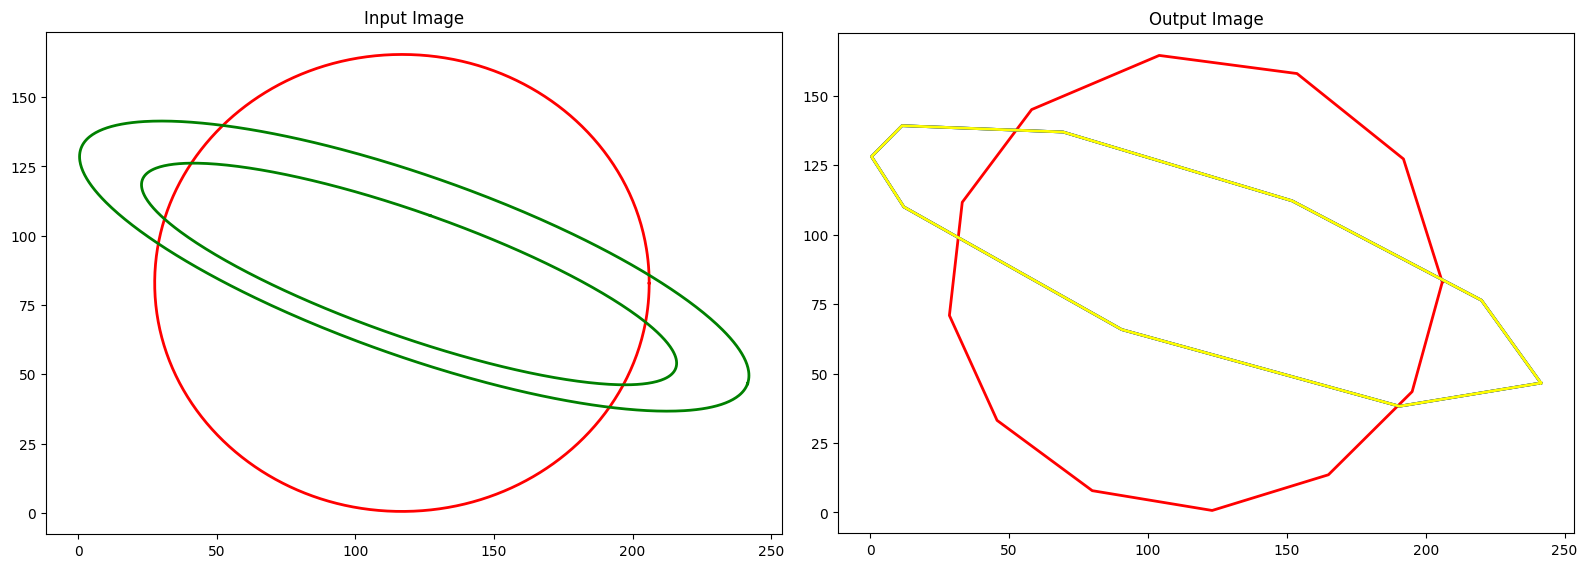

In [30]:
csv_path1 = "occlusion2_sol.csv"

paths_XYs = read_csv(csv_path1)

epsilon = 8
fitted_paths = regularize_paths(paths_XYs, epsilon)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(paths_XYs, 'Input Image', axs[0])
plot(fitted_paths, 'Output Image', axs[1])
plt.show()

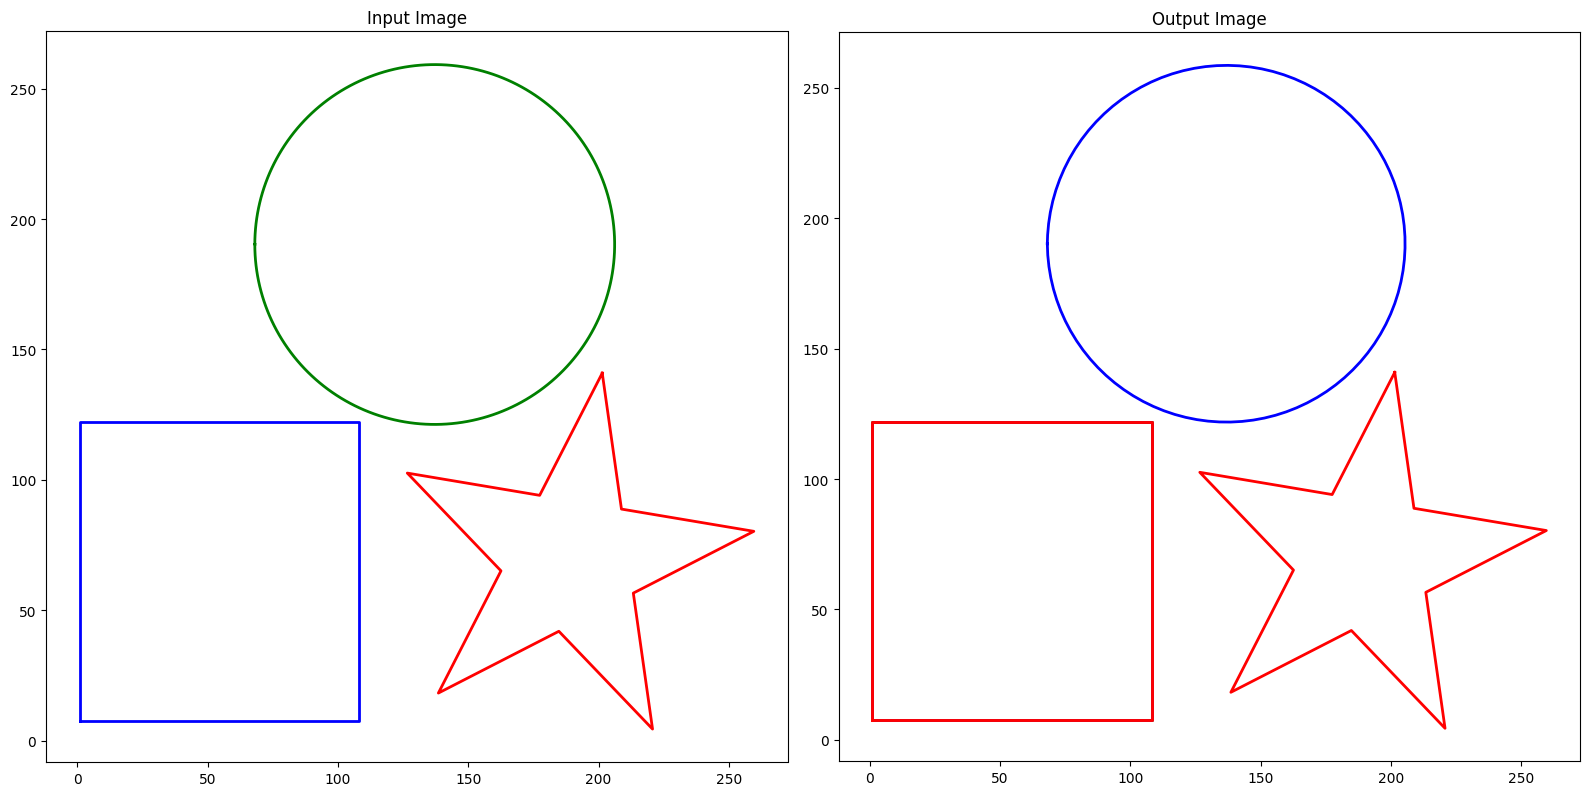

In [32]:
csv_path1 = "isolated_sol.csv"

paths_XYs = read_csv(csv_path1)

epsilon = 8
fitted_paths = regularize_paths(paths_XYs, epsilon)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(paths_XYs, 'Input Image', axs[0])
plot(fitted_paths, 'Output Image', axs[1])
plt.show()

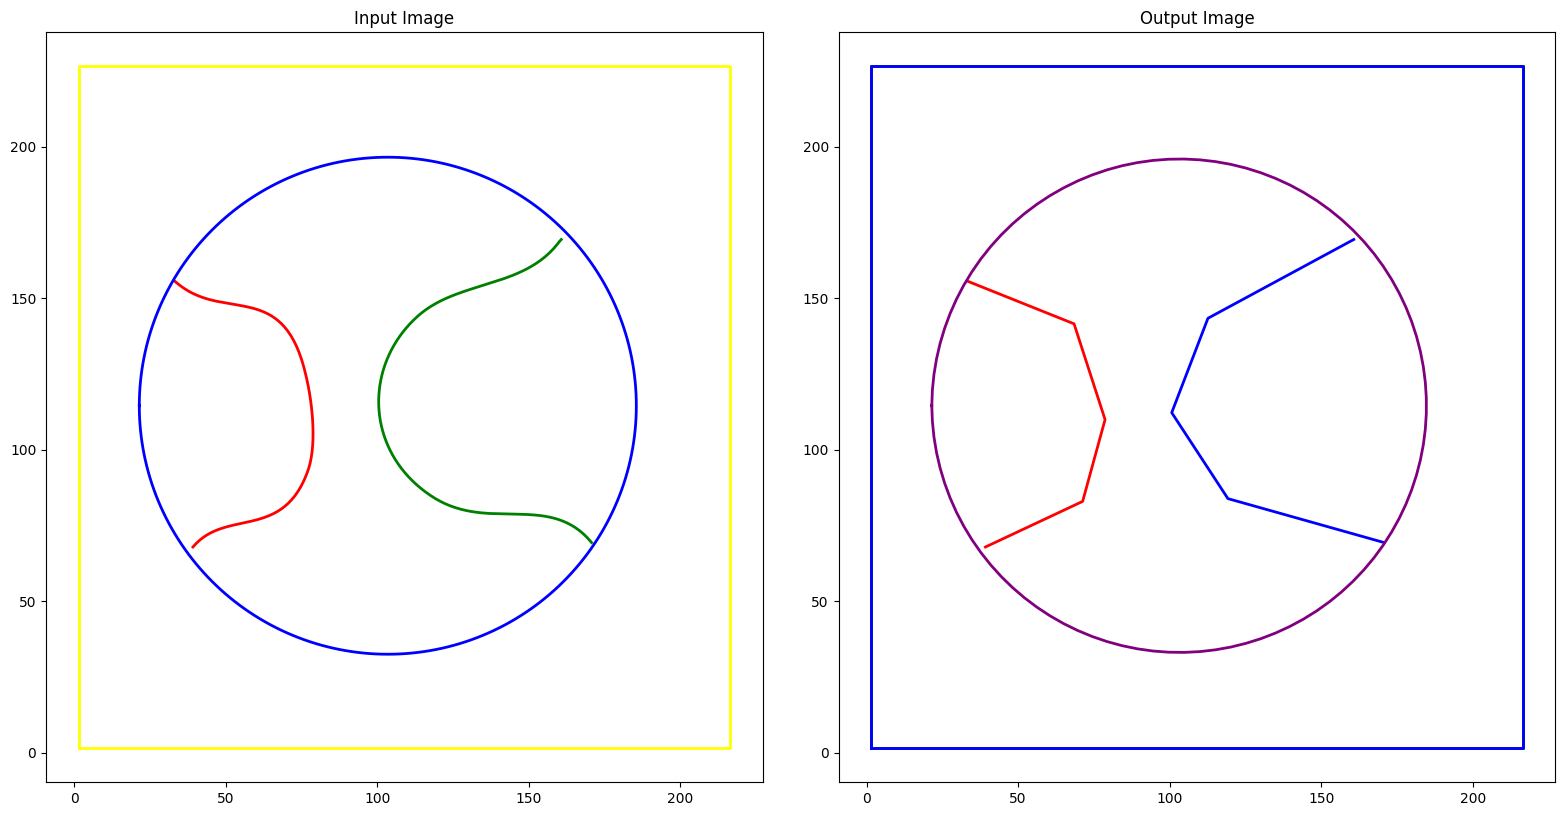

In [34]:
csv_path1 = "frag01_sol.csv"

paths_XYs = read_csv(csv_path1)

epsilon = 8
fitted_paths = regularize_paths(paths_XYs, epsilon)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(paths_XYs, 'Input Image', axs[0])
plot(fitted_paths, 'Output Image', axs[1])
plt.show()

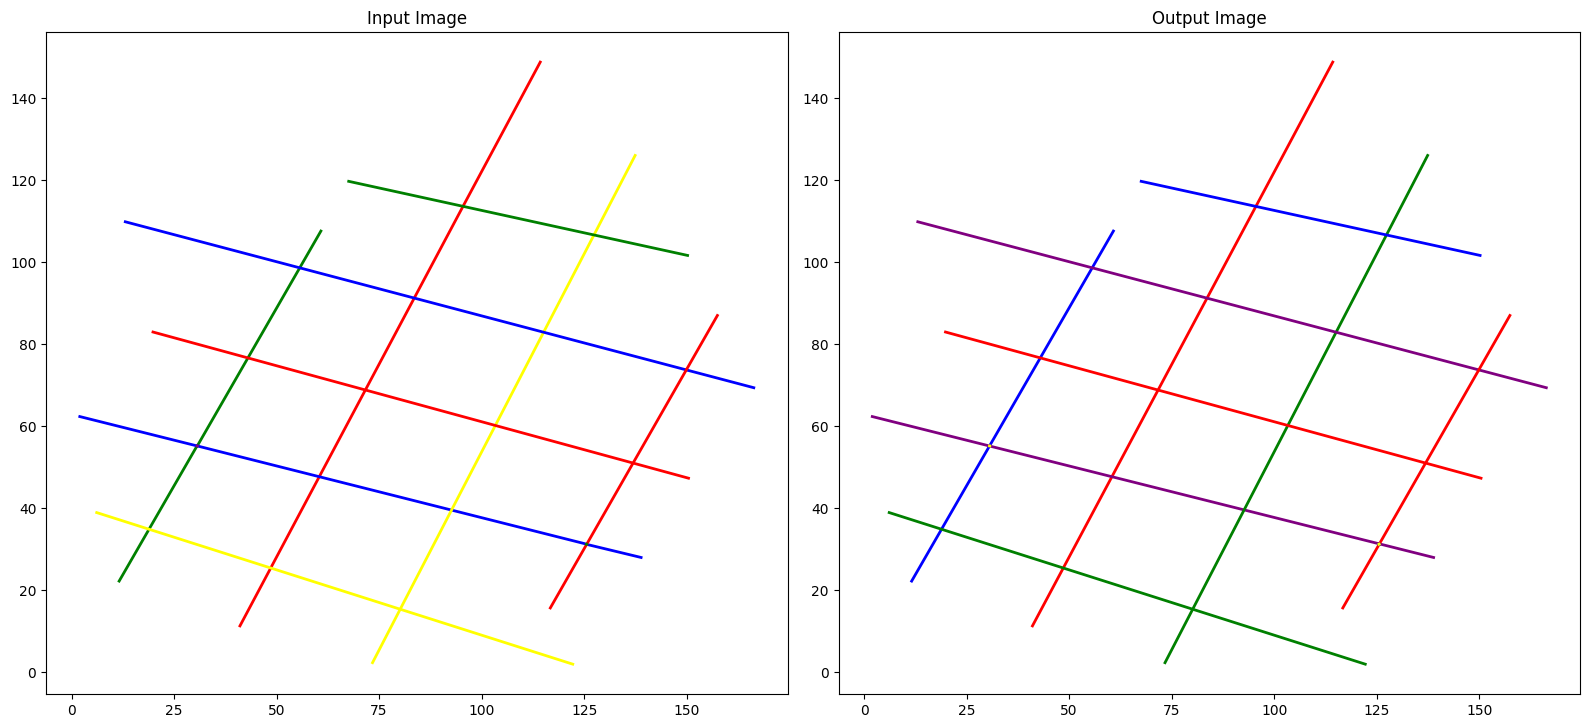

In [35]:
csv_path1 = "frag2_sol.csv"

paths_XYs = read_csv(csv_path1)

epsilon = 8
fitted_paths = regularize_paths(paths_XYs, epsilon)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(paths_XYs, 'Input Image', axs[0])
plot(fitted_paths, 'Output Image', axs[1])
plt.show()